## Modèle en production

Laurent Cetinsoy - Datadidacte

Une des supposition centrale pour qu'un modèle de machine learning marche est que la distribution des données ne diffère pas de celle des données d'entrainement.

On ne peut garantir la généralisation d'un modèle que si la distribution des données est similaire à celle de la distribution $ X_{prod} \tilde{} \,  P_{train}$

Ainsi, si les données que le modèle voient en production n'ont pas la même distribution (ne ressemblent pas) aux données de train, alors le modèle aura peu de chance de faire de bonne prédictions.

Il est donc important de surveille les données vues par le modèle en production.

Pour cela on va mesurer ce qu'on appelle le Data drift : on va mesurer à quel point les données s'écartent des données de train.

Et on pourra ainsi lever une alerte si c'est le cas.

## Utilisation Eurybia



En consultant la documentation de Eurybia (https://eurybia.readthedocs.io/en/latest/overview.html), expliquer le principe de fonctionnement de Euribya :

- A quoi sert le modèle de classification ?
- A-t-on besoin d’avoir les labels issus de la production pour pouvoir utiliser cette approche ?
- Quel est le critère pour déterminer qu’il y a un data-drift ?


- Ce modele de classification permet de predire si un element fait parti du dataset de training ou de production.
- Non on a pas besoin des labels issus de la production
- Si le modele fonctionne alors il y a un data-drift

Installer eurybia

Utiliser eurybia pour monitorer la distribution des données. Dans un premier temps faire en sorte que les données de prod (df_current) soient de la même distribution que vos données d’entraînement. Pour cela vous pouvez split le dataset en deux et décider que l'un est X_train et l'autre est X_prod. Vérifier que Eurybia pense que le modèle ne drift pas. Attention à ne pas inclure le label (qui serait ici price)



In [82]:
import pandas as pd
from eurybia import SmartDrift
from sklearn.model_selection import train_test_split
df = pd.read_csv('houses.csv')
X_train, X_prod = train_test_split(df, test_size=0.2, random_state=1)

sd = SmartDrift(
    df_current=X_train,
    df_baseline=X_prod,
)
sd.compile()
sd.generate_report(output_file="drift_report.html")

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7e897060c850>


Faire en sorte d'introduire un drift dans vos données. Par exemple (méthode assez bourine) ajouter +3 ou +4 à la colonne nb_rooms. Relancer eurybia et vérifier que la performance du modèle est bonne et qu'il y a donc un datadrift

In [83]:
X_train_drifted = X_train.copy()
X_train_drifted['nb_rooms'] = X_train_drifted['nb_rooms'] + 3
sd = SmartDrift(
    df_current=X_train_drifted,
    df_baseline=X_prod,
)
sd.compile()
sd.generate_report(output_file="drift_report.html")

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7e897060f1d0>


Faire en sorte de faire un drift plus subtile mais remarquable. Est-il détectable avec Eurybia ?

In [84]:
X_train_drifted_subtil = X_train.copy()
X_train_drifted_subtil['size'] = X_train_drifted_subtil['size'] * 1.1
sd = SmartDrift(
    df_current=X_train_drifted_subtil,
    df_baseline=X_prod,
)
sd.compile()
sd.generate_report(output_file="drift_report.html")

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7e89ee46b0d0>


Non il n'est pas detectable

## Alibaba detect

Dans cette partie on va utiliser la librairie https://github.com/SeldonIO/alibi-detect pour faire la détection de problèmes
Installer la librairie avec pip

Charger le jeu de donnée cifar10 avec keras et récupérer le train et le test puis,

Normaliser les données de train en faisant un MinMaxScaling (diviser par 255)

In [85]:
import torch
from torchvision import datasets, transforms

cifar10_train = datasets.CIFAR10(root="./data/", train=True, download=True)
cifar10_test = datasets.CIFAR10(root="./data/", train=False, download=True)

Dans le sous package alibbi_detect.datasets importer les  fonction fetch_cifar10c et corruption_types_cifar10c

In [86]:
from alibi_detect.datasets import fetch_cifar10c,  corruption_types_cifar10c

Afficher les types de corruption de données disponible avec la fonction corruption_types_cifar10c

In [87]:
corruption_types_cifar10c()

['brightness',
 'contrast',
 'defocus_blur',
 'elastic_transform',
 'fog',
 'frost',
 'gaussian_blur',
 'gaussian_noise',
 'glass_blur',
 'impulse_noise',
 'jpeg_compression',
 'motion_blur',
 'pixelate',
 'saturate',
 'shot_noise',
 'snow',
 'spatter',
 'speckle_noise',
 'zoom_blur']

Avec la fonction fetch_cifar10c récupérer des exemples corrompus de donnée ressemblant à cifar 10 et les stocker dans des variable X_corrupted et y_corrupted.

Vous choisirez 1 ou 2 corruptions parmis les suivantes : ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']

Vous spécifirez les argument severity=5 et return_X_y=True
attention le dataset peut être lourd si vous utilisez bcp de corruptions

In [88]:
corruption = ['gaussian_noise', 'motion_blur']
X_corrupted, y = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)

Normaliser les images corrompues

In [89]:
X_corrupted_normalized = X_corrupted / 255.0

Afficher plusieurs des images corrompues.

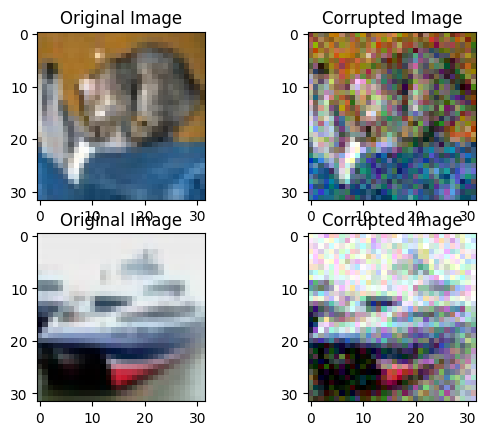

In [90]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(cifar10_test.data[0])
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(X_corrupted_normalized[0])
ax[0, 1].set_title("Corrupted Image")
ax[1, 0].imshow(cifar10_test.data[1])
ax[1, 0].set_title("Original Image")
ax[1, 1].imshow(X_corrupted_normalized[1])
ax[1, 1].set_title("Corrupted Image")
plt.show()

On va maintenant prendre un modèle entraîné sur cifar10 pour voir l'impact des performances sur le modèle.

Avec la fonction  fetch_tf_model du module alibi_detect.utils.fetching, charger le modèle préentraîné resnet32 sur cifar10


In [91]:
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
dataset = 'cifar10'
model_name = 'resnet32'
model = fetch_tf_model(dataset, model_name)

Calculer la performance du model sur le jeu de train et de test

In [92]:
import tensorflow as tf

X_train = cifar10_train.data / 255.0
X_train_tf = tf.convert_to_tensor(X_train)
X_test = cifar10_test.data / 255.0
X_test_tf = tf.convert_to_tensor(X_test)

y_train_tf = model.predict(X_train_tf)
y_test_tf = model.predict(X_test_tf)

313/313 [==============================] - 7s 22ms/step


In [93]:
y_pred_class = y_train_tf.argmax(axis=1)
print(f"Training accuracy: {tf.keras.metrics.Accuracy()(y_pred_class, tf.convert_to_tensor(cifar10_train.targets)).numpy()}")
y_pred_class = y_test_tf.argmax(axis=1)
print(f"Test accuracy: {tf.keras.metrics.Accuracy()(y_pred_class, tf.convert_to_tensor(cifar10_test.targets)).numpy()}")

Training accuracy: 0.6162999868392944
Test accuracy: 0.604200005531311


Calculer la performance du modèle sur le jeu de donnée corrompu. Vous devriez observer qu'il chute significativement

In [94]:
y_corrupted = model.predict(X_corrupted_normalized)

625/625 [==============================] - 12s 19ms/step


In [95]:
y_pred_class_corrupted = y_corrupted.argmax(axis=1)
print(f"Corrupted test accuracy: {tf.keras.metrics.Accuracy()(y_pred_class_corrupted, tf.convert_to_tensor(y)).numpy()}")

Corrupted test accuracy: 0.15845000743865967


On va maintenant voir comment détecter les changement de distributions de données.

Pour les données non tabulaire ou à haute dimension on procéde généralement en deux étapes :

1. Faire une réduction de dimension
2. Faire un test permettant de voir si les données projetées ont changé de distribution ou pas

Il existe plusieurs manières de faire de la réduction de dimension. La plus classique est la PCA.

Il est possible également d'utiliser des Auto-encoder

Le code suivant permet de créer la première partie (l'encoder) d'un auto-encoder simple qui nous servira à réduire les dimension des données.

In [96]:
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

Le drift detector a besoin d'une donnée de référence afin d'effectuer la comparaison avec les données à monitorer.
Créer une variable X_ref avec un échantillon aléatoire des données de test

In [97]:
import numpy as np

idx_ref = np.random.choice(len(X_train), size=len(X_train)//10, replace=False)
X_ref = X_train[idx_ref]

A quoi sert le test statistique kolmogorov smirnoff ?

Il permet de comparer deux distributions et de savoir si elles sont statistiquement différentes ou pas.

Instancier la classe KSDrift dans une variable nommée **detector**

Il faut lui passer le dataset de reference, une p value (prendre 0.05) et une fonction permettant de faire le preprocessing. On a créé la fonction pour vous


In [98]:
from alibi_detect.cd.tensorflow import preprocess_drift
preprocess_function = partial(preprocess_drift, model=encoder_net, batch_size=32)
from alibi_detect.cd import KSDrift
detector: KSDrift = KSDrift(
    X_ref,
    preprocess_fn=preprocess_function,
    p_val=0.05,
)

A laide du Drift detector et la méthode predict faire des prediction sur les données de test et sur les données corrompue pour voir si il détecte un changement de distribution

In [99]:
detector.predict(X_test)

{'data': {'is_drift': 0,
  'distance': array([0.0137, 0.0171, 0.0107, 0.0195, 0.0192, 0.0139, 0.0147, 0.0147,
         0.0153, 0.0136, 0.0177, 0.0207, 0.011 , 0.0114, 0.0106, 0.0229,
         0.0198, 0.0119, 0.0191, 0.0109, 0.0097, 0.0154, 0.0236, 0.0133,
         0.015 , 0.0098, 0.0159, 0.0293, 0.0115, 0.0166, 0.0143, 0.0136],
        dtype=float32),
  'p_val': array([0.5542654 , 0.28076285, 0.83590186, 0.15643357, 0.16903503,
         0.5354707 , 0.46299198, 0.46299198, 0.41209894, 0.5637441 ,
         0.24441569, 0.11335489, 0.8104732 , 0.7747722 , 0.8440764 ,
         0.05972292, 0.14459428, 0.7280201 , 0.17340982, 0.81909186,
         0.9093294 , 0.40394238, 0.04805017, 0.59245425, 0.43713686,
         0.9029034 , 0.36463714, 0.00641064, 0.76558286, 0.3138917 ,
         0.49863914, 0.5637441 ], dtype=float32),
  'threshold': 0.0015625},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.12.0',
  'detector_type': 'drift'}}

In [100]:
detector.predict(X_corrupted_normalized)

{'data': {'is_drift': 1,
  'distance': array([0.01085, 0.0152 , 0.0114 , 0.0158 , 0.01895, 0.01695, 0.0106 ,
         0.0236 , 0.0169 , 0.01365, 0.0249 , 0.01125, 0.01885, 0.01945,
         0.01055, 0.018  , 0.025  , 0.0114 , 0.0117 , 0.0091 , 0.01415,
         0.01485, 0.0382 , 0.0117 , 0.01725, 0.0082 , 0.0119 , 0.0252 ,
         0.0308 , 0.0109 , 0.01235, 0.01755], dtype=float32),
  'p_val': array([7.29744136e-01, 3.10648859e-01, 6.71648622e-01, 2.67956942e-01,
         1.11631677e-01, 1.98380128e-01, 7.55557358e-01, 2.28552949e-02,
         2.01083183e-01, 4.41454083e-01, 1.37881795e-02, 6.87606514e-01,
         1.15065105e-01, 9.57096368e-02, 7.60653496e-01, 1.47887945e-01,
         1.32475970e-02, 6.71648622e-01, 6.39652669e-01, 8.91834855e-01,
         3.96123201e-01, 3.37628037e-01, 1.65456040e-05, 6.39652669e-01,
         1.82748869e-01, 9.48731959e-01, 6.18353784e-01, 1.22233089e-02,
         9.90113826e-04, 7.24524260e-01, 5.70873737e-01, 1.68099493e-01],
        dtype=float

Dans ce cas la nous avons reussi a faire en sorte que le detecte un drift pour le dataset corrompu mais pas pour le dataset de test normal.
Je pense qu'il est quand meme important de noter que cette approche est assez sensible aux hyperparamètres (taille de l'echantillon de reference, p value, architecture de l'auto-encoder etc..)
Ici en prenant 1/10eme des données de train comme reference on a reussi a detecter le drift sur le dataset corrompu.